# Path analysis

In [16]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pylab import *

import igraph as ig # Need to install this in your virtual environment
from re import sub

import editdistance # Needs to be installed
from scipy.spatial.distance import pdist, squareform
# Usage:
# editdistance.eval('banana', 'bahama')

import seaborn as sns

In [17]:
import sys
sys.path.append('../../src/')
from utils.database import dbutils

conn = dbutils.connect()
cursor = conn.cursor()

In [3]:
nodes = pd.read_sql('select * from optourism.firenze_card_locations', con=conn)

In [4]:
df = pd.read_sql('select * from optourism.firenze_card_logs', con=conn)
df['museum_id'].replace(to_replace=39,value=38,inplace=True)
df['short_name'] = df['museum_id'].replace(dict(zip(nodes['museum_id'],nodes['short_name'])))
df['string'] = df['museum_id'].replace(dict(zip(nodes['museum_id'],nodes['string'])))
df['date'] = pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df['hour'] = pd.to_datetime(df['date']) + pd.to_timedelta(pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.hour, unit='h')
df['total_people'] = df['total_adults'] + df['minors']

In [5]:
# Helper function for making summary tables/distributions
def frequency(dataframe,columnname):
    out = dataframe[columnname].value_counts().to_frame()
    out.columns = ['frequency']
    out.index.name = columnname
    out.reset_index(inplace=True)
    out.sort_values('frequency',inplace=True,ascending=False)
    out['cumulative'] = out['frequency'].cumsum()/out['frequency'].sum()
    out['ccdf'] = 1 - out['cumulative']
    return out

I propose distinguishing _paths_ from _flows_. A path is an itinerary, and the flow is the number of people who take the flow. E.g., a family or a tour group produces one path, but adds mulitple people to the overall flow. 

We now build a transition graph, a directed graph where an edge represents a person going from one museum to another *within the same day*. 

We also produce the *transition matrix,* a row-normalized n-by-n matrix of the frequency of transition from the row node to the column node. If you take a vector of the current volumes in each location, and multiply that my the transition matrix, you get a prediction for the number of people on each node at the next time. This prediction can be refined with corrections for daily/weekly patterns and such. 

# Path analysis

To make paths: 

We want a dataframe with user, the museum they went from and the museum they went to, the number of people on the card, and the time of entry to the next museum. 

We will drop much of this data in creating paths, which will be concatenations of single-character codes for each museum.  

To track the first visit per day, we add a dummy "source" node that everybody starts each day from. We give it the character code " ", and can then split(" ") along it. 

In [6]:
df4 = df.groupby(['user_id','entry_time','date','hour','museum_name','short_name','string']).sum()['total_people'].to_frame() # Need to group in this order to be correct further down
df4.reset_index(inplace=True)

In [7]:
df4['from'] = 'source' # Initialize 'from' column with 'source'
df4['to'] = df4['short_name'] # Copy 'to' column with row's museum_name

In [8]:
make_link = (df4['user_id'].shift(1)==df4['user_id'])&(df4['date'].shift(1)==df4['date']) # Row indexes at which to overwrite 'source'
df4['from'][make_link] = df4['short_name'].shift(1)[make_link]

In [9]:
df4['s'] = ' ' # Initialize 'from' column with 'source'
df4['t'] = df4['string'] # Copy 'to' column with row's museum_name
df4['s'][make_link] = df4['string'].shift(1)[make_link]

In [10]:
# Concatenating the source column is not enough, it leaves out the last place in the path. 
# Need to add a second 'source' column that, for the last item in a day's path, contains two characters.
df4['s2'] = df4['s']
df4['s2'][df4['from'].shift(-1)=='source'] = (df4['s2'] + df4['t'])[df4['from'].shift(-1)=='source']
# Note: the above trick doesn't work for the last row of data. So, do this as well:
df4.iloc[-1:]['s2'] = df4.iloc[-1:]['s'] + df4.iloc[-1:]['t']

In [11]:
df5 = df4.groupby('user_id')['s2'].sum().to_frame() # sum() on strings concatenates 
df5.head()

,s2
user_id,
1459702,U3A DGVBC
1473903,U D2V PX
1473904,U D2V PX
1473905,N cDAC
1473906,PSUV AIMC2 cl


In [12]:
df6 = df5['s2'].apply(lambda x: pd.Series(x.strip().split(' '))) # Now split along strings. Takes a few seconds.
df6.head() # Note: 4 columns is correct, Firenze card is *72 hours from first use*, not from midnight of the day of first yse!

,0,1,2,3
user_id,,,,
1459702,U3A,DGVBC,NaN,NaN
1473903,U,D2V,PX,NaN
1473904,U,D2V,PX,NaN
1473905,N,cDAC,NaN,NaN
1473906,PSUV,AIMC2,cl,NaN


In [13]:
df6.head(50) # Data stories just fall out! People traveling together, splitting off, etc. We assume this but strong coupling is hard to ignore.

,0,1,2,3
user_id,,,,
1459702,U3A,DGVBC,NaN,NaN
1473903,U,D2V,PX,NaN
1473904,U,D2V,PX,NaN
1473905,N,cDAC,NaN,NaN
1473906,PSUV,AIMC2,cl,NaN
1473907,PSUV,AIMC2,cl,NaN
1474634,2D,U,MABm,NaN
1474636,2D,U,MABm,NaN
2014298,PN,A,NaN,NaN


In [14]:
fr1 = frequency(df5,'s2')

In [15]:
# INSIGHT: the top 15 paths are permutations of Duomo, Uffizi, Accademia. 
fr1.head(50)

,s2,frequency,cumulative,ccdf
0,D,337,0.006604,0.993396
1,U,218,0.010876,0.989124
2,AU,201,0.014815,0.985185
3,A,193,0.018597,0.981403
4,DA,189,0.022300,0.977700
5,ADU,186,0.025945,0.974055
6,UA,172,0.029316,0.970684
7,AD,168,0.032608,0.967392
8,DAU,145,0.035449,0.964551
9,U A,115,0.037703,0.962297


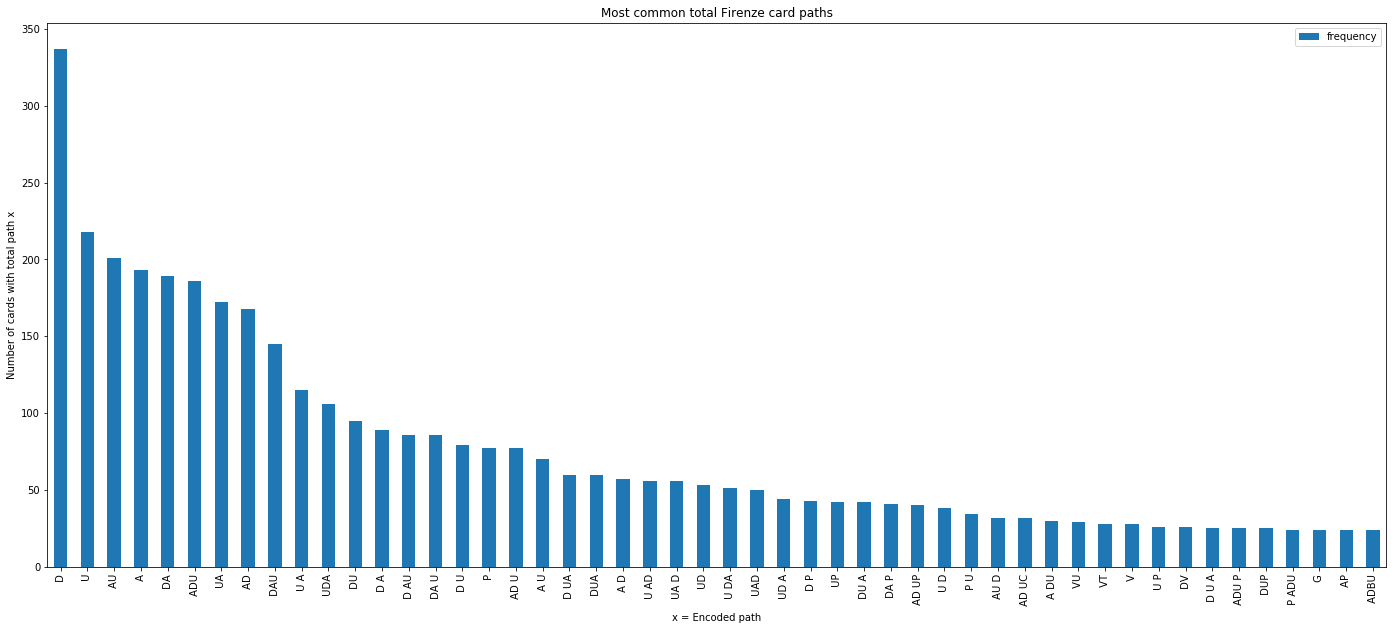

In [16]:
fr1.iloc[0:50].plot.bar(x='s2',y='frequency',figsize=(24,10))
plt.title('Most common total Firenze card paths')
plt.xlabel('x = Encoded path')
plt.ylabel('Number of cards with total path x')
# plt.yscale('log')
plt.show()

In [17]:
nodes

,museum_name,longitude,latitude,museum_id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,C
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,2
2,Battistero di San Giovanni,11.254966,43.773131,3,Opera del Duomo,D
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,l
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,b
5,Cappelle Medicee,11.252750,43.774914,6,Cappelle Medicee,c
6,Casa Buonarroti,11.263593,43.769850,7,Casa Buonarroti,7
7,Fondazione Primo Conti,11.292696,43.812167,8,Primo Conti,8
8,Fondazione Scienza e Tecnica _ Planetario,11.264543,43.776782,9,Planetario,_
9,Galleria degli Uffizi,11.255607,43.768526,10,Uffizi,U


In [18]:
df7 = df5['s2'].apply(lambda x: pd.Series(len(sub(' ','',x))))

In [19]:
df7.head()

,0
user_id,
1459702,8
1473903,6
1473904,6
1473905,5
1473906,11


In [20]:
df7.sort_values(0,ascending=False).head(10)

,0
user_id,
2066305,32
2066304,32
2057462,30
2057463,30
2086996,27
2086995,27
2075456,26
2075457,26
2030826,26


In [21]:
df6.loc[df7.sort_values(0,ascending=False).head(10).index]

,0,1,2,3
user_id,,,,
2066305,PLYsG3VT,Dcl2m9bC7EB,Ud0MgqOXIanNA,NaN
2066304,PLYsG3VT,Dcl2m9bC7EB,Ud0MgqOXIanNA,NaN
2057462,Ml2cDNbLPVT,UBC7amXIdS,A0GH3sY6n,NaN
2057463,Ml2cDNbLPVT,UBC7amXIdS,A0GH3sY6n,NaN
2086996,PbFHsC7E3GNV,DBU2mAIX,M0cln9d,NaN
2086995,PbFHsC7E3GNV,DBU2mAIX,M0cln9d,NaN
2075456,UGaB3Fp,Dl2cm0MOgXIANV,dPLCT,NaN
2075457,UGaB3Fp,Dl2cm0MOgXIANV,dPLCT,NaN
2030826,sC7SFmT,D2lcdNnIA,MEbPV,HG9aU


In [22]:
fr2 = frequency(df7,0)
fr2.head()

,0,frequency,cumulative,ccdf
0,6,5907,0.115753,0.884247
1,5,5632,0.226117,0.773883
2,7,5521,0.334307,0.665693
3,4,5516,0.442398,0.557602
4,8,4858,0.537595,0.462405


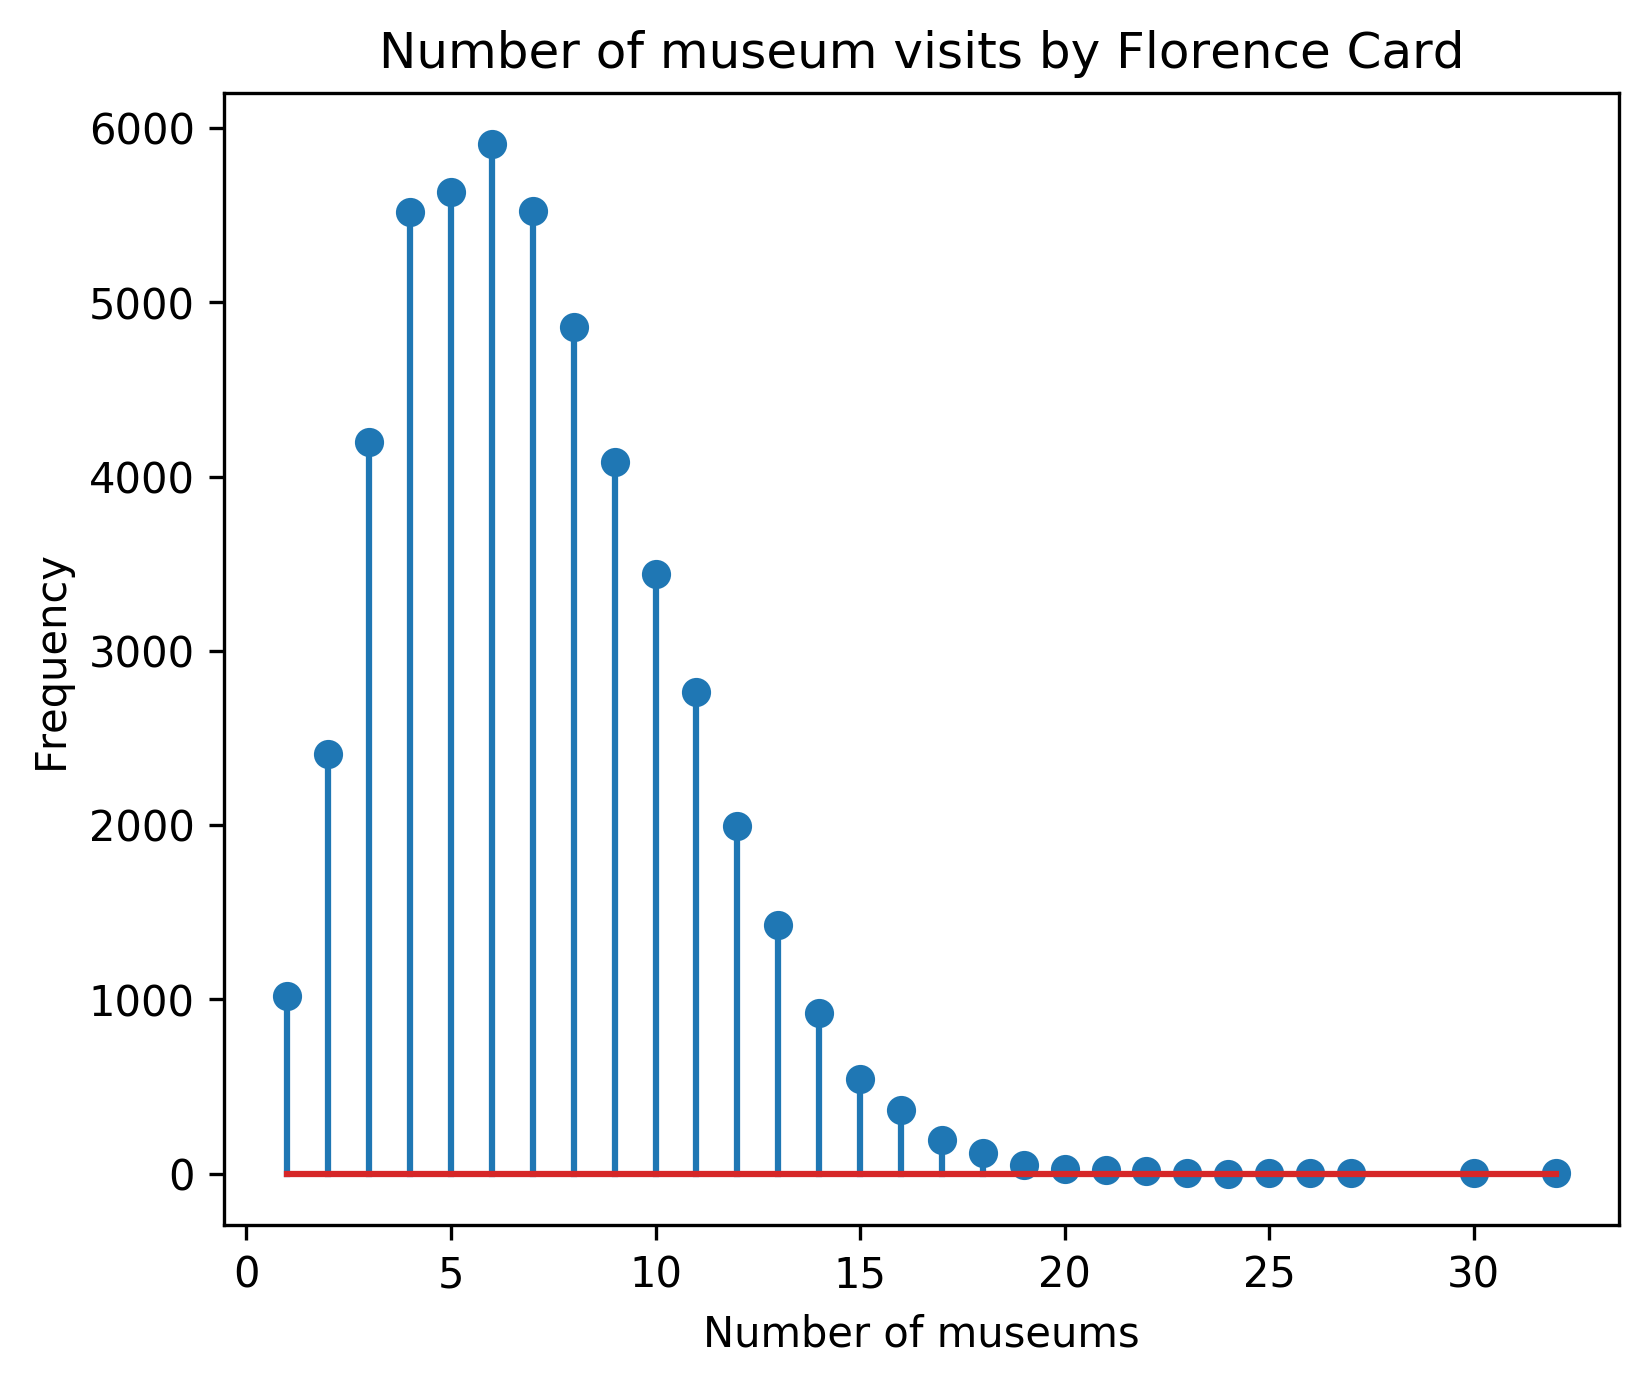

In [23]:
f, ax = plt.subplots(figsize=(6,5), dpi=300)
ax.stem(fr2[0],fr2['frequency'], linestyle='steps--')
# yscale('log')
# xscale('log')
ax.set_title('Number of museum visits by Florence Card')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of museums')
plt.show()
# NOTE: This is the number of *visits*, not people on those cards!! 
# (And, not number of museums visited, this counts multiple visits to the same museum as distinct)

In [24]:
df8 = df.groupby(['user_id','short_name','entry_time']).sum()['total_adults'].to_frame()
df8.head()

total_adults
user_id short_name         entry_time                       
1459702 Accademia          2016-06-22 15:49:00             1
        M. Bargello        2016-06-23 13:41:00             1
        M. Casa Dante      2016-06-22 14:26:00             1
        M. Galileo         2016-06-23 11:14:00             1
        M. Palazzo Vecchio 2016-06-23 12:57:00             1

In [25]:
# Cards with more than one entrance to same museum
df9 = df.groupby(['user_id','short_name']).sum()['total_adults'].to_frame()
df9.columns = ['number_of_entries']
df9['number_of_entries'] = df9['number_of_entries']
df9[df9['number_of_entries']>1].head(50)

number_of_entries
user_id short_name                               
2044654 M. Santa Maria Novella                  2
        Opera del Duomo                         2
        Uffizi                                  2
2045231 Accademia                               2
2046704 Accademia                               2
2052035 M. Galileo                              2
2059646 Santa Croce                             2
2059934 M. Palazzo Vecchio                      2
2062498 M. Archeologico                         2
2065347 M. Palazzo Vecchio                      2
2065878 Cappelle Medicee                        2
2067085 San Lorenzo                             2
2069270 M. Bargello                             2
2069663 M. Antropologia                         2
2078714 M. Novecento                            2
2088128 Pitti                                   2
2091065 Accademia                               2
        Opera del Duomo                         2
        Uffizi                                  2

In [26]:
df8.shape[0] # Number of entries

360534

In [27]:
df9.shape[0] # 12 repeat visits. Negligible.

360522

In [28]:
df9[df9['number_of_entries']==1].shape[0]

360503

In [29]:
df9[df9['number_of_entries']==2].shape[0]

19

In [30]:
df9[df9['number_of_entries']>2]

,,number_of_entries
user_id,short_name,


In [18]:
# # This is the number of people who entered on each card entry, not the number of repeat entries! 
# frequency(df.groupby(['user_id','short_name',]).count()['entry_time'].to_frame(),'entry_time')

In [32]:
df9 = df7.reset_index()
df10 = df8.reset_index()
df11 = df9.merge(df10).groupby('user_id').sum()
df11.columns = ['visits','total_people']
df11['persons_per_visit'] = df11['total_people']/df11['visits']
df11.head()

,visits,total_people,persons_per_visit
user_id,,,
1459702,64,8,0.125000
1473903,36,6,0.166667
1473904,36,6,0.166667
1473905,25,5,0.200000
1473906,121,11,0.090909


In [33]:
# df11[df11['persons_per_visit']>1].plot.scatter(x='visits',y='persons_per_visit')

We now want the following: a measure of similarity between adjacent rows, for detecting people traveling together (making the assumption that they bought Firenze cards consecutively). 

This is simplest to do naively: not use anything statistical, but just fuzzy matching through _edit distance_, which is the number of operations (insertions, deletions, swaps) needed to change one string into another (or, opreations on list elements to change one list to another). 

Since there are 3 days, and since we want slight deviations in otherwise identical large itineraries to count less, we calculate the following: a column with the edit distance between each pair of days between rows, summed, followed by a column with the total number of visits per row. 

In [34]:
# edit = pdist(X, lambda u, v: np.sqrt(((u-v)**2).sum()))

In [35]:
df6.fillna('',inplace=True)
df6.iloc[0:10]

,0,1,2,3
user_id,,,,
1459702,U3A,DGVBC,,
1473903,U,D2V,PX,
1473904,U,D2V,PX,
1473905,N,cDAC,,
1473906,PSUV,AIMC2,cl,
1473907,PSUV,AIMC2,cl,
1474634,2D,U,MABm,
1474636,2D,U,MABm,
2014298,PN,A,,


In [36]:
def editdist(pair):
    return editdistance.eval(pair[0],pair[1])

In [37]:
df7 = pd.concat([df6,df6.shift()],axis=1)

In [38]:
df7.columns = ['0','1','2','3','0+','1+','2+','3+']
df7.head()

,0,1,2,3,0+,1+,2+,3+
user_id,,,,,,,,
1459702,U3A,DGVBC,,,NaN,NaN,NaN,NaN
1473903,U,D2V,PX,,U3A,DGVBC,,
1473904,U,D2V,PX,,U,D2V,PX,
1473905,N,cDAC,,,U,D2V,PX,
1473906,PSUV,AIMC2,cl,,N,cDAC,,


In [39]:
# df8 = df7.iloc[:,[0,4,1,5,2,6,3,7]]
# df8.columns = ['0','0+','1','1+','2','2+','3','3+']
# df8.columns = ['0','0+','1','1+','2','2+','3','3+']
# df8.head()

In [40]:
df7['total_edit_distance'] = df7[['0','0+']].apply(editdist,axis=1) + df7[['1','1+']].apply(editdist,axis=1) + df7[['2','2+']].apply(editdist,axis=1) + df7[['3','3+']].apply(editdist,axis=1)
df7.head()

Exception TypeError: "object of type 'float' has no len()" in 'editdistance.bycython.eval' ignored
Exception TypeError: "object of type 'float' has no len()" in 'editdistance.bycython.eval' ignored
Exception TypeError: "object of type 'float' has no len()" in 'editdistance.bycython.eval' ignored
Exception TypeError: "object of type 'float' has no len()" in 'editdistance.bycython.eval' ignored


,0,1,2,3,0+,1+,2+,3+,total_edit_distance
user_id,,,,,,,,,
1459702,U3A,DGVBC,,,NaN,NaN,NaN,NaN,0
1473903,U,D2V,PX,,U3A,DGVBC,,,7
1473904,U,D2V,PX,,U,D2V,PX,,0
1473905,N,cDAC,,,U,D2V,PX,,6
1473906,PSUV,AIMC2,cl,,N,cDAC,,,10


In [41]:
df7['len'] = df7['0'].str.len() + df7['1'].str.len() + df7['2'].str.len() + df7['3'].str.len()
df7['len+'] = df7['0+'].str.len() + df7['1+'].str.len() + df7['2+'].str.len() + df7['3+'].str.len()
df7['len_tot'] = df7['len'] + df7['len+']
df7.head()

,0,1,2,3,0+,1+,2+,3+,total_edit_distance,len,len+,len_tot
user_id,,,,,,,,,,,,
1459702,U3A,DGVBC,,,NaN,NaN,NaN,NaN,0,8,NaN,NaN
1473903,U,D2V,PX,,U3A,DGVBC,,,7,6,8.0,14.0
1473904,U,D2V,PX,,U,D2V,PX,,0,6,6.0,12.0
1473905,N,cDAC,,,U,D2V,PX,,6,5,6.0,11.0
1473906,PSUV,AIMC2,cl,,N,cDAC,,,10,11,5.0,16.0


In [42]:
fr3 = frequency(df7[df7['total_edit_distance']==0],'len_tot')
fr3

,len_tot,frequency,cumulative,ccdf
0,12.0,2494,0.118221,0.881779
1,8.0,2384,0.231229,0.768771
2,10.0,2375,0.343809,0.656191
3,14.0,2248,0.450370,0.549630
4,16.0,1976,0.544037,0.455963
5,6.0,1792,0.628982,0.371018
6,18.0,1635,0.706485,0.293515
7,20.0,1399,0.772801,0.227199
8,22.0,1126,0.826176,0.173824
9,4.0,1039,0.875427,0.124573


In [43]:
frequency(df7[df7['total_edit_distance']==0],'len_tot')

,len_tot,frequency,cumulative,ccdf
0,12.0,2494,0.118221,0.881779
1,8.0,2384,0.231229,0.768771
2,10.0,2375,0.343809,0.656191
3,14.0,2248,0.450370,0.549630
4,16.0,1976,0.544037,0.455963
5,6.0,1792,0.628982,0.371018
6,18.0,1635,0.706485,0.293515
7,20.0,1399,0.772801,0.227199
8,22.0,1126,0.826176,0.173824
9,4.0,1039,0.875427,0.124573


In [44]:
df8 = df7.reset_index(inplace=False)
df8.reset_index(inplace=True)
df8.head()

,index,user_id,0,1,2,3,0+,1+,2+,3+,total_edit_distance,len,len+,len_tot
0,0,1459702,U3A,DGVBC,,,NaN,NaN,NaN,NaN,0,8,NaN,NaN
1,1,1473903,U,D2V,PX,,U3A,DGVBC,,,7,6,8.0,14.0
2,2,1473904,U,D2V,PX,,U,D2V,PX,,0,6,6.0,12.0
3,3,1473905,N,cDAC,,,U,D2V,PX,,6,5,6.0,11.0
4,4,1473906,PSUV,AIMC2,cl,,N,cDAC,,,10,11,5.0,16.0


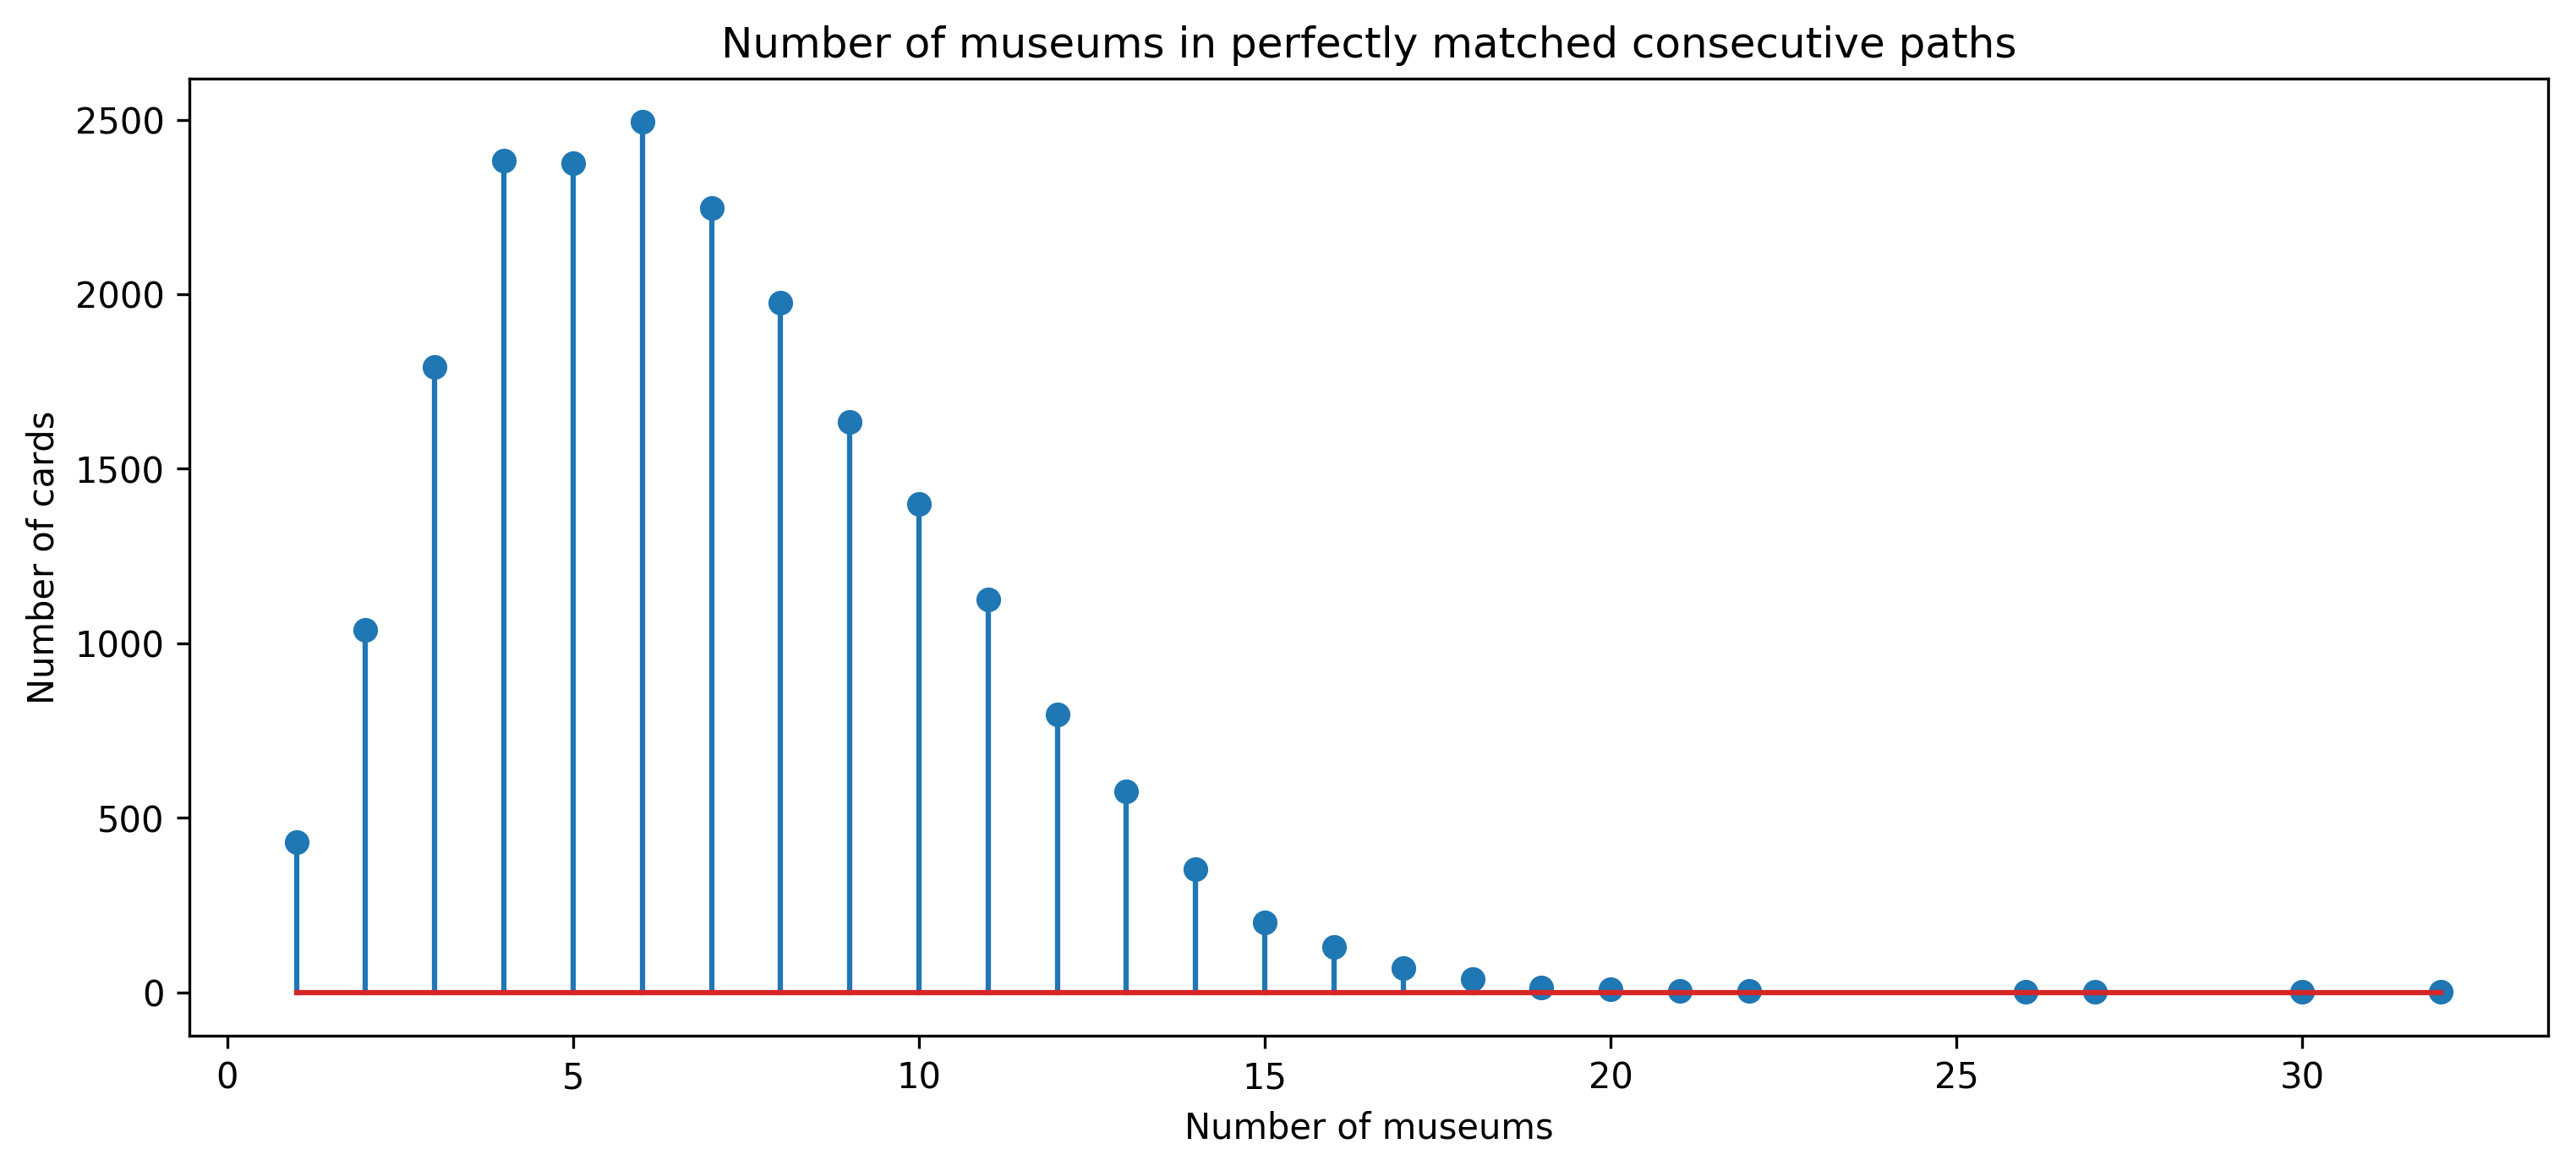

In [47]:
# df7[df7['total_edit_distance']==0].hist('len_tot',bins=100, grid=False, figsize=[16,8])
f, ax = plt.subplots(figsize=(12,5), dpi=300)
ax.stem(fr3['len_tot']/2,fr3['frequency'], linestyle='steps--')
# yscale('log')
# xscale('log')
ax.set_title('Number of museums in perfectly matched consecutive paths')
ax.set_ylabel('Number of cards')
ax.set_xlabel('Number of museums')
plt.show()
# NOTE: This is the number of *visits*, not people on those cards!! 
# (And, not number of museums visited, this counts multiple visits to the same museum as distinct)

In [ ]:
# df8.hist('user_id',bins=1000,figsize=[8,8])

In [ ]:
# df8[df8['user_id']>1500000].hist('user_id',bins=1000,figsize=[8,8])

In [ ]:
# df8.plot.scatter(x='index',y='total_edit_distance',figsize=[16,16], c=2+(df8['total_edit_distance']>0))
# sns.jointplot(x="index", y="total_edit_distance", data=df8)#, hue=(df9['total_edit_distance']==0))
# sns.jointplot(x="index", y="total_edit_distance", data=df8, kind='hex')

In [ ]:
sns.jointplot(x="total_edit_distance", y="len_tot", data=df8)

In [ ]:
sns.jointplot(x="total_edit_distance", y="len_tot", data=df8, kind='hex')

In [ ]:
sns.jointplot(x="total_edit_distance", y="len_tot", data=df8, kind='kde')

Now, need to extract consecutive rows of zero edit distance.

In [ ]:
df8['dist_gt_0'] = 1*(df8['total_edit_distance'] != 0)
# df8['offset'] = 1*(df8['zero_dist'] + df8['zero_dist'].shift()==0)
df8['group'] = cumsum(df8['dist_gt_0'])
df8.head(50)

In [ ]:
df9 = df8[['group','user_id']].groupby('group').count()
df9.columns = ['people']
df9.head()

In [ ]:
frequency(df9,'people')

In [3]:
# # The code below was my attempt to get a node for starting the day and ending the day from the paths. 
# # The problem is that this gives the number of _cards_, not number of people! I had to go back to the
# # dynamic edgelist construction anyway. 
# df6.head()

In [4]:
# df9 = df5['s2'].apply(lambda x: pd.Series(x.strip().split(' ')))
# df9.fillna(' ',inplace=True)
# df9['0_first'] = df9[0].apply(lambda x: pd.Series(x[0]))
# df9['0_last'] = df9[0].apply(lambda x: pd.Series(x[-1]))
# df9['0_len'] = df9[0].apply(lambda x: pd.Series(len(x)))
# df9['1_first'] = df9[1].apply(lambda x: pd.Series(x[0]))
# df9['1_last'] = df9[1].apply(lambda x: pd.Series(x[-1]))
# df9['1_len'] = df9[1].apply(lambda x: pd.Series(len(x)))
# df9['2_first'] = df9[2].apply(lambda x: pd.Series(x[0]))
# df9['2_last'] = df9[2].apply(lambda x: pd.Series(x[-1]))
# df9['2_len'] = df9[2].apply(lambda x: pd.Series(len(x)))
# df9['3_first'] = df9[3].apply(lambda x: pd.Series(x[0]))
# df9['3_last'] = df9[3].apply(lambda x: pd.Series(x[-1]))
# df9['3_len'] = df9[3].apply(lambda x: pd.Series(len(x)))
# df9.head()

In [5]:
# df9.replace(' ',np.nan,inplace=True)
# df9.head()

In [6]:
# from_home = frequency(df9[['0_first','1_first','2_first','3_first']].stack().to_frame(),0)[[0,'frequency']]
# from_home.columns = ['0','from_home']
# from_home.set_index('0',inplace=True)
# from_home.head()

In [7]:
# only = frequency(pd.concat(
#     [df9[(df9['0_len']==1)&(df9['0_first'].notnull())]['0_first'], 
#      df9[(df9['1_len']==1)&(df9['1_first'].notnull())]['1_first'], 
#      df9[(df9['2_len']==1)&(df9['2_first'].notnull())]['2_first'], 
#      df9[(df9['3_len']==1)&(df9['3_first'].notnull())]['3_first']
#     ],axis=0).to_frame()
# ,0)[[0,'frequency']]
# only.columns = ['0','only']
# only.set_index('0',inplace=True)
# only.head()

In [8]:
# to_home = frequency(df9[['0_last','1_last','2_last','3_last']].stack().to_frame(),0)[[0,'frequency']]
# to_home.columns = ['0','to_home']
# to_home.set_index('0',inplace=True)
# to_home.head()

In [9]:
# from_to_home = nodes.set_index('string')['short_name'].to_frame().join([from_home,to_home,only])
# from_to_home.set_index('short_name',inplace=True)
# from_to_home.columns = ['home_to_node','node_to_home','only_visit_of_day']
# # from_to_home['from_home'] = from_to_home['from_home_incl_only'] - from_to_home['only_visit_of_day']
# # from_to_home['to_home'] = from_to_home['to_home_incl_only'] - from_to_home['only_visit_of_day']
# from_to_home.head()

In [10]:
# from_to_home['home_to_node'].sort_values(ascending=False).to_frame().head(20)

In [11]:
# from_to_home['node_to_home'].sort_values(ascending=False).to_frame().head(20)

In [12]:
# from_to_home.reset_index(inplace=True)

In [13]:
# from_to_home

In [14]:
# supp_edges = pd.DataFrame({'from':['home']*from_to_home.shape[0] + from_to_home['short_name'].tolist(),
#                           'to':from_to_home['short_name'].tolist() + ['home']*from_to_home.shape[0],
#                           'weight':from_to_home['home_to_node'].tolist() + from_to_home['node_to_home'].tolist() })



In [15]:
# supp_edges.dropna(how='any',inplace=True)
# supp_edges

In [ ]:
frequency(df6,0).head()

In [ ]:
frequency(df6,1).head()

In [ ]:
frequency(df6,2).head()

In [ ]:
frequency(df6,3).head()

Now, I want a set of scatterplots between these frequencies.

In [33]:
pt = pd.concat([frequency(df6,0),frequency(df6,1),frequency(df6,2),frequency(df6,3)])
pt['daily_path'] = pt[0].replace(np.nan, '', regex=True) + pt[1].replace(np.nan, '', regex=True) + pt[2].replace(np.nan, '', regex=True) + pt[3].replace(np.nan, '', regex=True)
pt.drop([0,1,2,3,'ccdf','cumulative'],axis=1,inplace=True)
pt.head()

,frequency,daily_path
0,3572,D
1,2317,U
2,1585,P
3,1486,A
4,1232,V


In [34]:
pt2 = pt.groupby('daily_path').sum()
pt2.sort_values('frequency', inplace=True, ascending=False)
pt2.head()

,frequency
daily_path,
D,5932
P,5643
U,5420
A,3604
V,1909


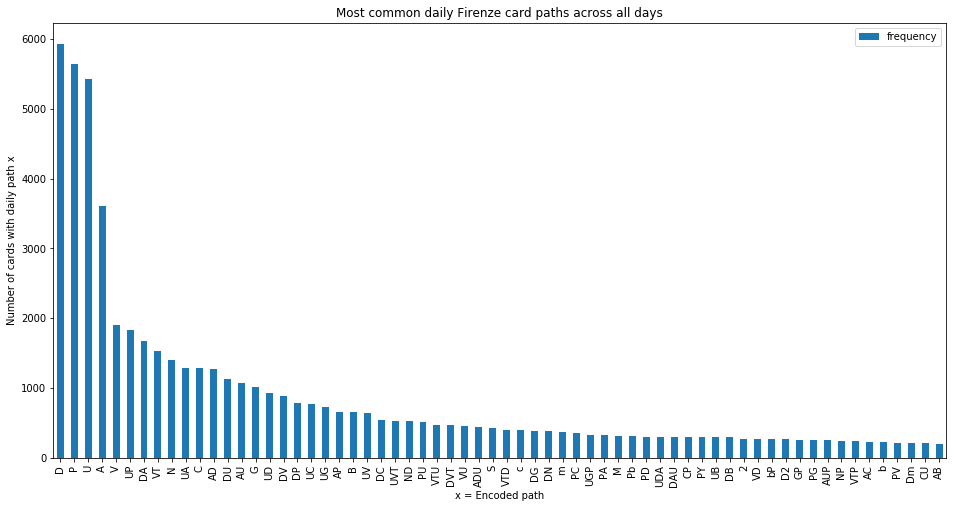

In [35]:
pt2[pt2['frequency']>200].plot.bar(figsize=(16,8))
plt.title('Most common daily Firenze card paths across all days')
plt.xlabel('x = Encoded path')
plt.ylabel('Number of cards with daily path x')
# plt.yscale('log')
plt.show()

In [36]:
nodes.head()

,museum_name,longitude,latitude,museum_id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,C
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,2
2,Battistero di San Giovanni,11.254966,43.773131,3,Opera del Duomo,D
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,l
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,b


In [37]:
# For reference, here are the displayed museums
# nodes[['string','short_name']].set_index('string').reindex(['D','P','U','A','V','T','N','C','G','B','S','c','m','M','b','Y','2'])
nodes[nodes['string'].isin(['D','P','U','A','V','T','N','C','G','B','S','c','m','M','b','Y','2'])][['string','short_name']]

,string,short_name
0,C,Santa Croce
1,2,San Lorenzo
2,D,Opera del Duomo
4,b,Brancacci
5,c,Cappelle Medicee
9,U,Uffizi
10,A,Accademia
19,M,M. San Marco
20,N,M. Santa Maria Novella
23,G,M. Galileo


In [38]:
df6[pd.isnull(df6[0].str[0])].head()

,0,1,2,3
user_id,,,,


In [26]:
df6.to_csv('encoded_paths.csv')

In [27]:
nodes.to_csv('encoded_paths_legend.csv')

In [39]:
df6.values

array([['U3A', 'DGVBC', nan, nan],
       ['U', 'D2V', 'PX', nan],
       ['U', 'D2V', 'PX', nan],
       ..., 
       ['D', nan, nan, nan],
       ['D', nan, nan, nan],
       ['D', nan, nan, nan]], dtype=object)